In [65]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [55]:
import pandas as pd
import numpy as np
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
import gzip 
import tqdm
import requests



def harmonic_sum(data, scale_factor=1, cap=None):
    """
    Returns an harmonic sum for the data passed
    Args:
        data (list): list of floats to compute the harmonic sum from
        scale_factor (float): a scaling factor to multiply to each datapoint. Defaults to 1
        cap (float): if not None, never return an harmonic sum higher than the cap value.
    Returns:
        harmonic_sum (float): the harmonic sum of the data passed
    """
    
    if isinstance(data, pd.Series):
        data = data.tolist()

    data.sort(reverse=True)
    harmonic_sum = sum(s / ((i+1) ** scale_factor) for i, s in enumerate(data))
    
    # Applying cap:
    if cap is not None and harmonic_sum > cap:
        return cap
      
    return harmonic_sum


def add_missing_efo(efo_ids):
    missing_efo_map = {}
    for efo_id in efo_ids:
        url = f'https://www.ebi.ac.uk/ols/api/terms?short_form={efo_id}'
        r = requests.get(url)
        data = r.json()

        missing_efo_map[efo_id] = data['_embedded']['terms'][0]['label']

    return missing_efo_map
        

def add_missing_genes(genes):
    missing_gene_map = {}
    for ensembl_id in genes:
        r = requests.get(f'http://rest.ensembl.org/lookup/id/{ensembl_id}?content-type=application/json;expand=0')
        missing_gene_map[ensembl_id] = r.json()['display_name']
        
    return missing_gene_map


def so_lookup(so_term):
    '''
    Function to do the OLS lookup, returns with the label.
    '''
    
    url = f'https://www.ebi.ac.uk/ols/api/terms?short_form={so_term}'
    r = requests.get(url)
    data = r.json()

    return data['_embedded']['terms'][0]['label']
    

def read_eva_evidences(source_file):
    
    parsed_data = []

    with gzip.open(source_file) as f:
        for line in f:
            data = json.loads(line)
            evidence = {
                'type': data['type'],
                'target': data['unique_association_fields']['gene'],
                'disease': data['unique_association_fields']['phenotype'].split('/')[-1],
                'rsid': data['unique_association_fields']['variant_id'],
                'clinvar_acces': data['unique_association_fields']['clinvarAccession'],   
            }

            if data['type'] == 'genetic_association':
                evidence.update({
                    'score': data['evidence']['variant2disease']['resource_score']['value'],
                    'star': data['evidence']['variant2disease']['clinvar_rating']['star_rating'],
                    'review_status': data['evidence']['variant2disease']['clinvar_rating']['review_status'],
                    'clinical_significance': data['evidence']['variant2disease']['clinical_significance'],
                    'so_code':  data['evidence']['gene2variant']['functional_consequence'].split('/')[-1],
                })

            elif data['type'] == 'somatic_mutation':
                evidence.update({
                    'score': data['evidence']['resource_score']['value'],
                    'star': data['evidence']['clinvar_rating']['star_rating'],
                    'review_status': data['evidence']['clinvar_rating']['review_status'],
                    'clinical_significance': data['evidence']['clinical_significance'],
                    'so_code': data['evidence']['known_mutations'][0]['functional_consequence'].split('/')[-1],
                })
            parsed_data.append(evidence)

    return pd.DataFrame(parsed_data)


##
## Function to get evidence score based on a set of weights:
##
def calculate_evidence_score(row, weights):
    """
    Based on the weights of the given clumns the evidence sore is calcualted as follows:
    sum[1->i](wi*di)
    """
    
    # Generate evidence score:
    score = 0
    for col in weights.index:
        score += row[col] * weights[col]

    return score

##
## calculating auc and enrichment for plotting:
##
def calculate_auc(association_score):
    
    # calculate auc:
    fpr, tp, thresholds = roc_curve(association_score.poscon, association_score.association_score)
    auc = roc_auc_score(association_score.poscon, association_score.association_score)

    # Calculate enrichment:
    top_n = len(association_score.loc[association_score.poscon])

    recovery = (
        association_score
        .sort_values('association_score', ascending=False)
        .head(top_n)
        .query('poscon == True')
        .association_score
        .size
    )

    enrichment = len(association_score) * recovery / top_n ** 2

    return {
        'fpr': fpr,
        'tpr': tp,
        'auc': auc,
        'recovery': recovery,
        'enrichment': enrichment
    }

##
## Plot ROC curve for many tests
##
def plot_auc_all(results):

    # Draw baseline:
    pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

    # Calculated curves:
    for label, data in results.items():
        pyplot.plot(data['fpr'], data['tpr'], marker='.', markersize = 1, label=f'{label} (auc:{data["auc"]:.2}, enr:{data["enrichment"]:.2}x)') # variant count

    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')

    # Add legend:
    pyplot.legend(bbox_to_anchor=(1, 1))

##
## Running the classifier are calculate parameters:
##
def get_fit_parameters(df, columns):

    # Build classifier:
    if len(columns) > 1:
        rf = RandomForestClassifier(class_weight='balanced')
        rf.fit(df[columns],df.poscon)  

        # Extracting weight:
        print('Extract weights...')
        weight_series = pd.Series(rf.feature_importances_, index=columns)
        print(weight_series.sort_values())

        # Combining evidence score in to association score:
        association_score = (
            df
            .set_index(['disease', 'target'])
            .apply(calculate_evidence_score, args=(weight_series,), axis=1)
            .groupby(['target','disease'])
            .apply(harmonic_sum)
            .rename('association_score')
            .to_frame()
            .merge(df[['target','disease','poscon']].drop_duplicates(), on=['target','disease'], how='left')
        )
    else:
        association_score = (
            df
            .groupby(['target','disease'])
            [columns[0]]
            .apply(harmonic_sum)
            .rename('association_score')
            .to_frame()
            .merge(df[['target','disease','poscon']].drop_duplicates(), on=['target','disease'], how='left')
        )

    return calculate_auc(association_score)    



##
## Hot-one ecode set of columns
##
def hot1(df, columns, prefix):

    # Get unique clinical significance values:
    feature_df = df[['target','disease','poscon'] + columns].copy()

    # Generate dummy features from clinical significance values:
    feature_df = pd.get_dummies(feature_df, prefix=prefix, columns=columns)

    cols = [x for x in feature_df.columns if f'{prefix}_' in x]
    return  get_fit_parameters(feature_df, cols)

    # Generate dummy features from clinical significance values:
    clin_sig_split = pd.get_dummies(clin_sig_split, prefix='clin_sig', columns=['clinical_signif'])

    # Update dummy columns were more then one clinical significance value is available:
    for i, row in clin_sig_split.loc[clin_sig_split.clinical_significance.apply(lambda x: True if len(x)>1 else False)].iterrows():
        for sig_val in row['clinical_significance']:
            clin_sig_split.loc[i,f'clin_sig_{sig_val}'] = 1

In [52]:
eva = pd.read_parquet('EVA_processed_2020.10.25.parquet')


eva_consequences_order_map = {
    # Least severe (no change in protein sequence):
    'downstream_gene_variant': 1,
    'upstream_gene_variant': 1,
    'intron_variant': 1,
    'non_coding_transcript_exon_variant': 1,
    '3_prime_UTR_variant': 1,
    '5_prime_UTR_variant': 1,
    'mature_miRNA_variant': 1,
    'synonymous_variant': 1,
    'stop_retained_variant': 1,    
    
    # Moderately severe (change in protein sequence):
    'coding_sequence_variant': 2,
    'incomplete_terminal_codon_variant': 2,
    'splice_region_variant': 2,
    'protein_altering_variant': 2,
    'missense_variant': 2,
    'inframe_deletion': 2,
    'inframe_insertion': 2,
    
    # Most severe (severly changed sequence):
    'start_lost': 3,
    'stop_lost': 3,
    'frameshift_variant': 3,
    'stop_gained': 3,
    'splice_donor_variant': 3,
    'splice_acceptor_variant': 3,
    'trinucleotide_repeat_expansion': 3,
    'short_tandem_repeat_expansion': 3,
    'transcript_ablation': 3
}

# Review status is an ordinal variable. Mapping to numbers:
review_status_order_map = {
    # Less severe:
    'no assertion provided': 1,
    'no assertion criteria provided': 1,
    
    # More severe:
    'criteria provided, conflicting interpretations': 2,
    'criteria provided, single submitter': 2,
    'criteria provided, multiple submitters, no conflicts': 2,
    
    # Most severe:
    'reviewed by expert panel': 3,
    'practice guideline': 3
}

clinical_significance_mapping = {
    # Less severe:
    'association not found': 1,  
    'benign': 1,
    'not provided': 1,
    'uncertain significance': 1,    
    'likely benign': 1,    
    
    # More severe:
    'conflicting interpretations of pathogenicity': 2,   
    'other': 2,
    'likely pathogenic' : 2,
    'risk factor': 2,
    'affects': 2,
    
    # Most severe:
    'association': 3,
    'drug response': 3,
    'protective':3,
    'pathogenic' : 3,
}

# Processing clinical significance:
eva['clinical_signif'] = (
    eva
    .clinical_significance
    .apply(lambda x: max([clinical_significance_mapping[y] for y in x]))
)
eva['combined_feature'] = eva.apply(lambda x: f"{eva_consequences_order_map[x['consequence']]}{x['clinical_signif']}", axis=1)

# crude weights for consequence and review status:
eva = eva.assign(consequence_weighted = eva.consequence.map(eva_consequences_order_map),
           review_status_weighted = eva.review_status.map(review_status_order_map))
    
eva.head()

,type,target,disease,rsid,clinvar_acces,score,star,review_status,clinical_significance,so_code,...,efo_id,label,literature,pharmaproject,pharmaproject_approved,poscon,clinical_signif,combined_feature,consequence_weighted,review_status_weighted
0,genetic_association,ENSG00000154803,Orphanet_2903,rs886037610,RCV000003542,1.000000e-07,0,no assertion criteria provided,[pathogenic],SO_0001589,...,Orphanet_2903,Familial spontaneous pneumothorax,False,False,False,False,3,33,3,1
1,genetic_association,ENSG00000103197,Orphanet_805,rs137854012,RCV000042664,1.000000e-07,0,no assertion provided,[not provided],SO_0001589,...,Orphanet_805,Tuberous sclerosis,False,False,False,False,1,31,3,1
2,genetic_association,ENSG00000103197,Orphanet_805,rs137854007,RCV000042927,1.000000e-07,0,no assertion provided,[not provided],SO_0001589,...,Orphanet_805,Tuberous sclerosis,False,False,False,False,1,31,3,1
3,genetic_association,ENSG00000103197,Orphanet_805,rs397515245,RCV000055557,1.000000e-07,0,no assertion provided,[not provided],SO_0001822,...,Orphanet_805,Tuberous sclerosis,False,False,False,False,1,21,2,1
4,genetic_association,ENSG00000129422,EFO_0002950,rs1554507029,RCV000161533,1.000000e-07,0,no assertion provided,[not provided],SO_0001574,...,EFO_0002950,pregnancy,False,False,False,False,1,31,3,1


In [56]:
print(len(eva))
print(len(eva[['target','disease']].drop_duplicates()))
print(len(eva.loc[eva.poscon]))
print(len(eva.loc[eva.poscon][['target','disease']].drop_duplicates()))

807198
29960
41755
557


# Exploring review status

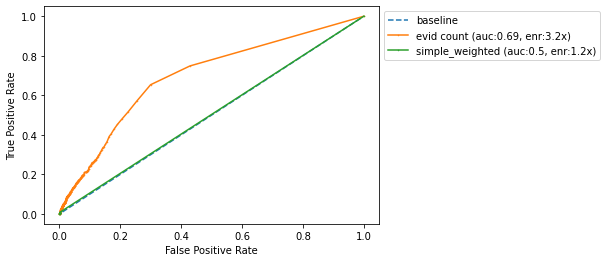

In [64]:
# hot1(db, columns, prefix)
results = {}

# baseline:
columns = ['baseline']
results['evid count'] = get_fit_parameters(eva.assign(baseline=1),columns)

# review status - simple weighted:
results['simple_weighted'] = get_fit_parameters(eva, ['review_status_weighted'])
       
# review status - hot one weighted:
results['one-hot encoded'] = hot1(eva, ['review_status'], 'rev')

plot_auc_all(results)

Extract weights...
rev_1    0.47
rev_0    0.53
dtype: float64


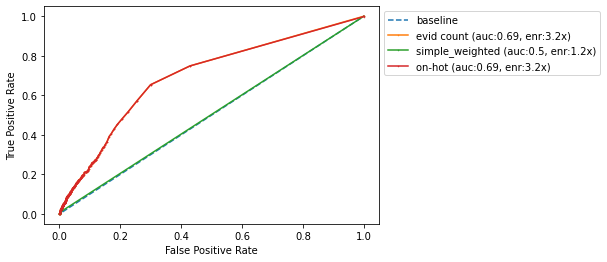

In [59]:
# updated review status weight:
review_status_order_map = {
    # Less severe:
    'no assertion provided': 0,
    'no assertion criteria provided': 0,
    'criteria provided, conflicting interpretations': 0,

    # 
    'criteria provided, single submitter': 0,
    'criteria provided, multiple submitters, no conflicts': 0,
    'reviewed by expert panel': 1,
    'practice guideline': 1
}

review_status_order_map = {
    # Less severe:
    'no assertion provided': 0,
    'no assertion criteria provided': 0,
    'criteria provided, conflicting interpretations': 0,

    # 
    'criteria provided, single submitter': 0,
    'criteria provided, multiple submitters, no conflicts': 0,
    'reviewed by expert panel': 1,
    'practice guideline': 1
}

eva = eva.assign(review_status_weighted = eva.review_status.map(review_status_order_map))

# hot1(db, columns, prefix)
results = {}

# baseline:
columns = ['baseline']
results['evid count'] = get_fit_parameters(eva.assign(baseline=1),columns)

# review status - simple weighted:
results['simple_weighted'] = get_fit_parameters(eva, ['review_status_weighted'])
       
# review status - hot one weighted:
# results['on-hot'] = hot1(eva, ['review_status_weighted'], 'rev')

plot_auc_all(results)    

Extract weights...
rev_0    0.49
rev_1    0.51
dtype: float64


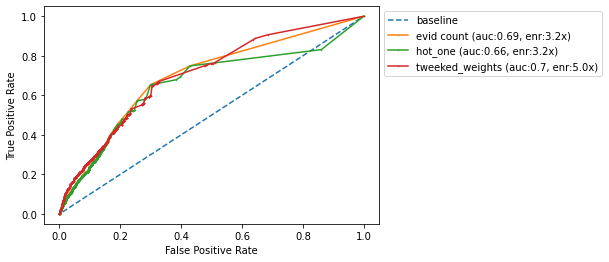

In [10]:
weights = pd.Series([0.000107, 0.001254, 0.003246, 0.003372, 0.005201, 0.007977, 0.014480, 0.023414, 0.038207, 0.060810, 0.061685, 0.086585, 0.098472, 0.595189],\
          index=["clin_sig_association not found", "clin_sig_association", "clin_sig_drug response", "clin_sig_protective", "clin_sig_affects", "clin_sig_conflicting interpretations of pathogenicity", "clin_sig_risk factor", "clin_sig_not provided", "clin_sig_likely benign", "clin_sig_other", "clin_sig_pathogenic", "clin_sig_uncertain significance", "clin_sig_benign", "clin_sig_likely pathogenic"])

# hot1(db, columns, prefix)
results = {}

# baseline:
columns = ['baseline']
results['evid count'] = get_fit_parameters(eva.assign(baseline=1),columns)
       
# review status - hot one weighted:
results['hot_one'] = hot1(eva, ['review_status_weighted'], 'rev')


# baseline:
columns = ['tweeked_weights']
results['tweeked_weights'] = get_fit_parameters(eva.loc[eva.clinical_significance.apply(lambda x: True if 'benign' not in x else False)].assign(tweeked_weights=eva.clinical_significance.apply(lambda x: max([clinical_significance_mapping[y] for y in x]))),columns)


plot_auc_all(results)    

## Focus on clinical significance

Extract weights...
clin_association not found                           0.000112
clin_association                                     0.001421
clin_drug response                                   0.003141
clin_protective                                      0.003419
clin_affects                                         0.004924
clin_conflicting interpretations of pathogenicity    0.007824
clin_risk factor                                     0.010912
clin_not provided                                    0.023657
clin_likely benign                                   0.038913
clin_other                                           0.066161
clin_pathogenic                                      0.066301
clin_uncertain significance                          0.090348
clin_benign                                          0.107229
clin_likely pathogenic                               0.575637
dtype: float64


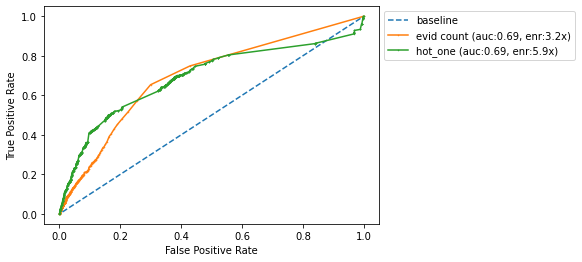

In [23]:
# hot1(db, columns, prefix)
results = {}

# baseline:
columns = ['baseline']
results['evid count'] = get_fit_parameters(eva.assign(baseline=1),columns)
       
# clinical significance hot one encoded:
filtered = (
    eva
    .assign(clin=eva.clinical_significance.apply(lambda x: x[0]))
    .loc[eva.clinical_significance.apply(lambda x: True if len(x) == 1 else False)]    
)
results['hot_one'] = hot1(filtered, ['clin'], 'clin')

plot_auc_all(results)    

Extract weights...
clin_2    0.006446
clin_1    0.015887
clin_0    0.414465
clin_3    0.563202
dtype: float64


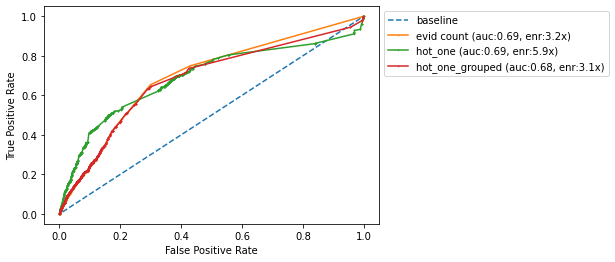

In [24]:
original_weights = {
    "clin_association not found": 0.000100,
    "clin_association": 0.000870,
    "clin_protective": 0.002940,
    "clin_drug response": 0.004327,
    "clin_affects": 0.005142,
    "clin_risk factor": 0.009534,
    "clin_conflicting interpretations of pathogenicity": 0.009556,
    "clin_not provided": 0.029492,
    "clin_likely benign": 0.038542,
    "clin_pathogenic": 0.056639,
    "clin_other": 0.067141,
    "clin_uncertain significance": 0.098912,
    "clin_benign": 0.118888,
    "clin_likely pathogenic": 0.557916
}

modified_weights = {
    "association not found": 0,
    "benign": 0,
    "likely benign": 0,
    "not provided": 0,
    
    
    "other": 1,
    "conflicting interpretations of pathogenicity": 1,
    
    
    "association": 2,
    "protective": 2,
    "drug response": 2,
    "affects": 2,
    
    "risk factor": 3,
    "pathogenic": 3,
    "uncertain significance": 3,
    "likely pathogenic": 3  
}

results['hot_one_grouped'] = hot1(filtered.assign(mapped_clin=filtered.clin.map(modified_weights)), ['mapped_clin'], 'clin')
plot_auc_all(results)    


In [30]:
grouped_Scores = {
   "2": 0.006446,
   "1": 0.015887,
   "0": 0.414465,
   "3": 0.563202
}

filtered['upd_score'] = filtered.assign(mapped_clin=filtered.clin.map(modified_weights)).mapped_clin.astype(str).map(grouped_Scores)
filtered.head()

,type,target,disease,rsid,clinvar_acces,score,star,review_status,clinical_significance,so_code,...,literature,pharmaproject,pharmaproject_approved,poscon,clinical_signif,combined_feature,consequence_weighted,review_status_weighted,clin,upd_score
0,genetic_association,ENSG00000154803,Orphanet_2903,rs886037610,RCV000003542,1.000000e-07,0,no assertion criteria provided,[pathogenic],SO_0001589,...,False,False,False,False,3,33,3,0,pathogenic,0.563202
1,genetic_association,ENSG00000103197,Orphanet_805,rs137854012,RCV000042664,1.000000e-07,0,no assertion provided,[not provided],SO_0001589,...,False,False,False,False,1,31,3,0,not provided,0.414465
2,genetic_association,ENSG00000103197,Orphanet_805,rs137854007,RCV000042927,1.000000e-07,0,no assertion provided,[not provided],SO_0001589,...,False,False,False,False,1,31,3,0,not provided,0.414465
3,genetic_association,ENSG00000103197,Orphanet_805,rs397515245,RCV000055557,1.000000e-07,0,no assertion provided,[not provided],SO_0001822,...,False,False,False,False,1,21,2,0,not provided,0.414465
4,genetic_association,ENSG00000129422,EFO_0002950,rs1554507029,RCV000161533,1.000000e-07,0,no assertion provided,[not provided],SO_0001574,...,False,False,False,False,1,31,3,0,not provided,0.414465


In [32]:
association_score = (
    filtered
    .groupby(['target','disease'])
    ['upd_score']
    .apply(harmonic_sum)
    .rename('association_score')
    .to_frame()
    .merge(filtered[['target','disease','poscon']].drop_duplicates(), on=['target','disease'], how='left')
)

association_score

,target,disease,association_score,poscon
0,ENSG00000000419,Orphanet_137,2.713576,False
1,ENSG00000000971,EFO_0001365,2.749501,True
2,ENSG00000000971,EFO_0003884,0.563202,False
3,ENSG00000000971,EFO_0009909,0.414465,False
4,ENSG00000000971,EFO_1001155,2.760474,False
...,...,...,...,...
29950,ENSG00000288602,EFO_0001663,0.563202,False
29951,ENSG00000288636,HP_0001258,1.223386,False
29952,ENSG00000288636,Orphanet_306674,1.714906,False
29953,ENSG00000288637,Orphanet_397968,2.901080,False


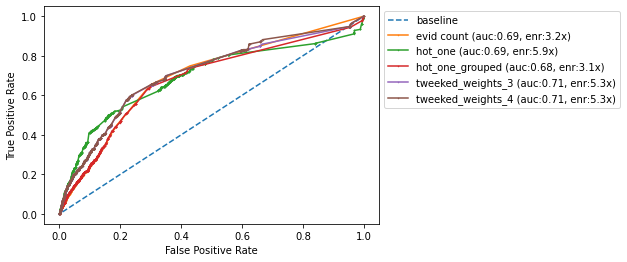

In [39]:
clinical_significance_mapping = {
    # Less severe:
    'association not found': 0.01,  
    'benign': 0.01,
    'not provided': 0.01,
    'likely benign': 0.01,    
    
    # More severe:
    'conflicting interpretations of pathogenicity': 0.3,   
    'other': 0.3,
    'uncertain significance': 0.3,
    
    # Moderately severe
    'risk factor': 0.5,
    'affects': 0.5,
    
    # Most severe:
    'likely pathogenic' : 1,
    'association': 1,
    'drug response': 1,
    'protective': 1,
    'pathogenic': 1,
}



columns = ['tweeked_weights']
results['tweeked_weights_4'] = get_fit_parameters((eva
                                                  .assign(tweeked_weights=eva.clinical_significance.apply(lambda x: max([clinical_significance_mapping[y] for y in x])))),columns)

plot_auc_all(results)    




In [49]:
clinical_significance_mapping = {
    # Less severe:
    'association not found': 0.01,  
    'benign': 0.01,
    'not provided': 0.01,
    'likely benign': 0.01,    
    
    # More severe:
    'conflicting interpretations of pathogenicity': 0.3,   
    'other': 0.3,
    'uncertain significance': 0.3,
    
    # Moderately severe
    'risk factor': 0.5,
    'affects': 0.5,
    
    # Most severe:
    'likely pathogenic' : 1,
    'association': 1,
    'drug response': 1,
    'protective': 1,
    'pathogenic': 1,
}

clinical_significances =  [
    "pathogenic",
    'uncertain significance',
    'cicaful',
    'pocok'
]

scores = [clinical_significance_mapping[x] for x in clinical_significances if x in clinical_significance_mapping ]


In [51]:
max(scores)

1

## Consequence

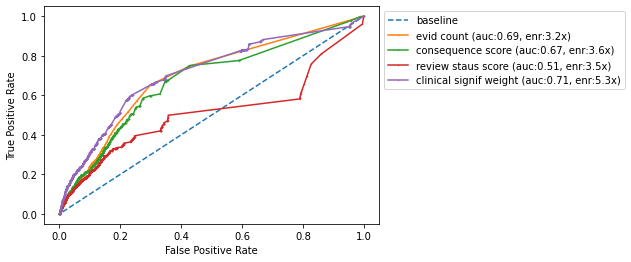

In [70]:
eva_consequences_order_map = {
    'downstream_gene_variant': 0.6,
    'upstream_gene_variant': 0.6,
    'intron_variant': 0.65,
    'non_coding_transcript_exon_variant': 0.65,
    '3_prime_UTR_variant': 0.65,
    '5_prime_UTR_variant': 0.65,
    'mature_miRNA_variant': 0.65,
    'synonymous_variant': 0.65,
    'stop_retained_variant': 0.65,    
    
    'coding_sequence_variant': 0.95,
    'incomplete_terminal_codon_variant': 0.9,
    'splice_region_variant': 0.95,
    'protein_altering_variant': 0.7,
    'missense_variant': 0.7,
    'inframe_deletion': 0.7,
    'inframe_insertion': 0.7,
    
    'start_lost': 0.95,
    'stop_lost': 0.9,
    'frameshift_variant': 0.95,
    'stop_gained': 0.95,
    'splice_donor_variant': 0.95,
    'splice_acceptor_variant': 0.95,
    'trinucleotide_repeat_expansion': 1,
    'short_tandem_repeat_expansion': 1,
    'transcript_ablation': 1
}

# hot1(db, columns, prefix)
results = {}

# baseline:
columns = ['baseline']
results['evid count'] = get_fit_parameters(eva.assign(baseline=1),columns)
       
# 
results['consequence score'] = get_fit_parameters(eva.assign(consequence_score=eva.consequence.map(eva_consequences_order_map)),['consequence_score'])


review_status_order_map = {
    # Less severe:
    'no assertion provided': 0,
    'no assertion criteria provided': 1,
    'criteria provided, conflicting interpretations': 2,

    # 
    'criteria provided, single submitter': 3,
    'criteria provided, multiple submitters, no conflicts': 4,
    'reviewed by expert panel': 5,
    'practice guideline': 6
}

results['review staus score'] = get_fit_parameters(eva.assign(review_staus_score=eva.review_status.map(review_status_order_map)),['review_staus_score'])


clinical_significance_mapping = {
    # Less severe:
    'association not found': 0.01,  
    'benign': 0.01,
    'not provided': 0.01,
    'likely benign': 0.01,    
    
    # More severe:
    'conflicting interpretations of pathogenicity': 0.3,   
    'other': 0.3,
    'uncertain significance': 0.3,
    
    # Moderately severe
    'risk factor': 0.5,
    'affects': 0.5,
    
    # Most severe:
    'likely pathogenic' : 1,
    'association': 1,
    'drug response': 1,
    'protective': 1,
    'pathogenic': 1,
}



columns = ['tweeked_weights']
results['clinical signif weight'] = get_fit_parameters((eva
                                                  .assign(tweeked_weights=eva.clinical_significance.apply(lambda x: max([clinical_significance_mapping[y] for y in x])))),columns)



plot_auc_all(results)   

Extract weights...
consequence_score     0.260067
tweeked_weights       0.260333
review_staus_score    0.479599
dtype: float64


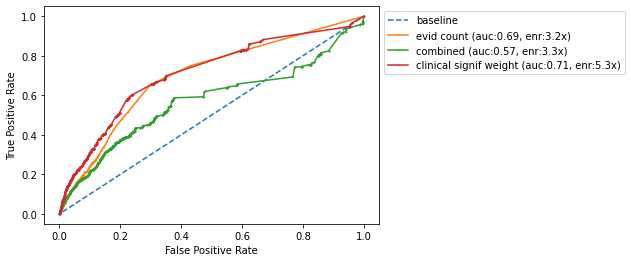

In [74]:
# hot1(db, columns, prefix)
results = {}

# Adding baseline:
columns = ['baseline']
results['evid count'] = get_fit_parameters(eva.assign(baseline=1),columns)

# Combine columns:
columns = ['tweeked_weights', 'review_staus_score', 'consequence_score']
featured = eva.copy()
featured = featured.assign(
    tweeked_weights = featured.clinical_significance.apply(lambda x: max([clinical_significance_mapping[y] for y in x])),
    review_staus_score = featured.review_status.map(review_status_order_map),
    consequence_score = featured.consequence.map(eva_consequences_order_map)
)
results['combined'] = get_fit_parameters(featured,columns)

results['clinical signif weight'] = get_fit_parameters((eva
                                                  .assign(tweeked_weights=eva.clinical_significance.apply(lambda x: max([clinical_significance_mapping[y] for y in x])))),['tweeked_weights'])


plot_auc_all(results)

In [77]:
df = pd.DataFrame({'col_a':['b','c','d','c','e'], 'col_b':['1','2','2','3','3']})

In [78]:
df

,col_a,col_b
0,b,1
1,c,2
2,d,2
3,c,3
4,e,3


In [2]:
import pandas as pd
eva = pd.read_parquet('EVA_processed_2020.10.25.parquet')
eva.head()

,type,target,disease,rsid,clinvar_acces,score,star,review_status,clinical_significance,so_code,gene_id,symbol,consequence,efo_id,label,literature,pharmaproject,pharmaproject_approved,poscon
0,genetic_association,ENSG00000154803,Orphanet_2903,rs886037610,RCV000003542,1.000000e-07,0,no assertion criteria provided,[pathogenic],SO_0001589,ENSG00000154803,FLCN,frameshift_variant,Orphanet_2903,Familial spontaneous pneumothorax,False,False,False,False
1,genetic_association,ENSG00000103197,Orphanet_805,rs137854012,RCV000042664,1.000000e-07,0,no assertion provided,[not provided],SO_0001589,ENSG00000103197,TSC2,frameshift_variant,Orphanet_805,Tuberous sclerosis,False,False,False,False
2,genetic_association,ENSG00000103197,Orphanet_805,rs137854007,RCV000042927,1.000000e-07,0,no assertion provided,[not provided],SO_0001589,ENSG00000103197,TSC2,frameshift_variant,Orphanet_805,Tuberous sclerosis,False,False,False,False
3,genetic_association,ENSG00000103197,Orphanet_805,rs397515245,RCV000055557,1.000000e-07,0,no assertion provided,[not provided],SO_0001822,ENSG00000103197,TSC2,inframe_deletion,Orphanet_805,Tuberous sclerosis,False,False,False,False
4,genetic_association,ENSG00000129422,EFO_0002950,rs1554507029,RCV000161533,1.000000e-07,0,no assertion provided,[not provided],SO_0001574,ENSG00000129422,MTUS1,splice_acceptor_variant,EFO_0002950,pregnancy,False,False,False,False


In [4]:
len(eva[['target','disease','clinvar_acces']].drop_duplicates())

804484

In [6]:
len(eva)

807198

In [9]:
eva.loc[eva[['target','disease','clinvar_acces']].duplicated(keep=False)].sort_values(['clinvar_acces'])

,type,target,disease,rsid,clinvar_acces,score,star,review_status,clinical_significance,so_code,gene_id,symbol,consequence,efo_id,label,literature,pharmaproject,pharmaproject_approved,poscon
493362,genetic_association,ENSG00000196712,Orphanet_636,rs137854560,RCV000000372,1.000000e-07,2,"criteria provided, multiple submitters, no con...",[pathogenic],SO_0001587,ENSG00000196712,NF1,stop_gained,Orphanet_636,Neurofibromatosis type 1,False,False,False,False
493361,somatic_mutation,ENSG00000196712,Orphanet_636,rs137854560,RCV000000372,1.000000e+00,2,"criteria provided, multiple submitters, no con...",[pathogenic],SO_0001587,ENSG00000196712,NF1,stop_gained,Orphanet_636,Neurofibromatosis type 1,False,False,False,False
18953,somatic_mutation,ENSG00000196712,Orphanet_636,rs137854559,RCV000000385,1.000000e+00,1,"criteria provided, single submitter",[pathogenic],SO_0001587,ENSG00000196712,NF1,stop_gained,Orphanet_636,Neurofibromatosis type 1,False,False,False,False
18954,genetic_association,ENSG00000196712,Orphanet_636,rs137854559,RCV000000385,1.000000e-07,1,"criteria provided, single submitter",[pathogenic],SO_0001587,ENSG00000196712,NF1,stop_gained,Orphanet_636,Neurofibromatosis type 1,False,False,False,False
626260,somatic_mutation,ENSG00000134982,Orphanet_733,rs137854573,RCV000000845,1.000000e+00,1,"criteria provided, single submitter",[pathogenic],SO_0001587,ENSG00000134982,APC,stop_gained,Orphanet_733,Familial adenomatous polyposis,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713880,genetic_association,ENSG00000213614,Orphanet_845,rs121907977,RCV001250228,1.000000e-07,1,"criteria provided, single submitter",[pathogenic],SO_0001583,ENSG00000213614,HEXA,missense_variant,Orphanet_845,Tay-Sachs disease,False,False,False,False
713763,genetic_association,ENSG00000213614,Orphanet_845,rs759157781,RCV001250237,1.000000e-07,1,"criteria provided, single submitter",[pathogenic],SO_0001583,ENSG00000213614,HEXA,missense_variant,Orphanet_845,Tay-Sachs disease,False,False,False,False
713764,genetic_association,ENSG00000213614,Orphanet_845,rs759157781,RCV001250237,1.000000e-07,1,"criteria provided, single submitter",[pathogenic],SO_0001583,ENSG00000213614,HEXA,missense_variant,Orphanet_845,Tay-Sachs disease,False,False,False,False
783921,genetic_association,ENSG00000204248,EFO_0001063,rs1583334125,RCV001250801,1.000000e-07,1,"criteria provided, single submitter",[uncertain significance],SO_0001583,ENSG00000204248,COL11A2,missense_variant,EFO_0001063,deafness,False,False,False,False
